<a href="https://colab.research.google.com/github/gharashim/RL/blob/main/9_%EC%A0%95%EC%B1%85%EA%B2%BD%EC%82%AC%EB%B2%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch

print("CUDA available:", torch.cuda.is_available())
print("Device name:", torch.cuda.get_device_name(0))


CUDA available: True
Device name: Tesla T4


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import gymnasium as gym


class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_size):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, 128)    # 입력 차원 명시
        self.fc2 = nn.Linear(128, action_size)  # 출력 차원 명시

    def forward(self, x):
        x     = F.relu(self.fc1(x))
        probs = F.softmax(self.fc2(x), dim = 1)   # dim=1 명시
        return probs


class Agent:
    def __init__(self):
        self.gamma = 0.98
        self.lr = 0.0002
        self.state_dim = 4
        self.action_size = 2

        self.memory = []  # (log_prob, reward) 저장
        self.pi = PolicyNetwork(self.state_dim, self.action_size)
        self.optimizer = optim.Adam(self.pi.parameters(), lr = self.lr)

    def get_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0)  # (1, state_dim) 모양의 Tensor
        probs = self.pi(state)                         # softmax 확률 출력
        m = torch.distributions.Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)       # 정수 action, 로그확률 반환


    def add(self, reward, log_prob):
        data = (reward, log_prob)
        self.memory.append(data)


    def update(self):
        # self.pi.zero_grad()
        self.optimizer.zero_grad()

        G, loss = 0, 0

        for reward, log_prob in reversed(self.memory):
            G = reward + self.gamma * G

        for reward, log_prob in reversed(self.memory):
            loss += -log_prob * G

        loss.backward()
        self.optimizer.step()
        self.memory = []

In [ ]:
env = gym.make('CartPole-v1', render_mode="rgb_array")
state = env.reset()[0]
agent = Agent()

action, log_prob = agent.get_action(state)
print('행동: ', action)
print('로그확률: ', log_prob)

G = 100.0  # 더미 가중치
J = G * log_prob
print('J:', J)

# 기울기 구하기
J.backward()


행동:  0
로그확률:  tensor([-0.7608], grad_fn=<SqueezeBackward1>)
J: tensor([-76.0811], grad_fn=<MulBackward0>)


In [ ]:
episodes = 3000
env = gym.make('CartPole-v1', render_mode="rgb_array")
agent = Agent()
reward_history = []

for episode in range(episodes):
    state = env.reset()[0]
    done = False
    total_reward = 0

    while not done:
        action, log_prob = agent.get_action(state) # 행동 선택
        # 행동 수행
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        agent.add(reward, log_prob) # 보상과 행동의 확률을 에이전트에 추가
        state = next_state      # 상태 전이
        total_reward += reward  # 보상 총합 계산

    agent.update() # 정책 갱신
    reward_history.append(total_reward)

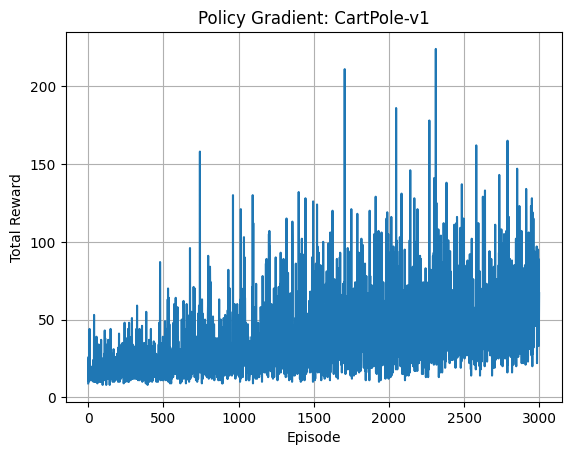

In [ ]:
import matplotlib.pyplot as plt

plt.plot(reward_history)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Policy Gradient: CartPole-v1')
plt.grid(True)
plt.show()


cuda
Episode 100, Reward: 12.0
Episode 200, Reward: 18.0
Episode 300, Reward: 14.0
Episode 400, Reward: 40.0
Episode 500, Reward: 14.0
Episode 600, Reward: 38.0
Episode 700, Reward: 134.0
Episode 800, Reward: 112.0
Episode 900, Reward: 65.0
Episode 1000, Reward: 215.0
Episode 1100, Reward: 150.0
Episode 1200, Reward: 204.0
Episode 1300, Reward: 139.0
Episode 1400, Reward: 233.0
Episode 1500, Reward: 363.0
Episode 1600, Reward: 199.0
Episode 1700, Reward: 142.0
Episode 1800, Reward: 164.0
Episode 1900, Reward: 343.0
Episode 2000, Reward: 205.0
Episode 2100, Reward: 210.0
Episode 2200, Reward: 417.0
Episode 2300, Reward: 280.0
Episode 2400, Reward: 485.0
Episode 2500, Reward: 263.0
Episode 2600, Reward: 500.0
Episode 2700, Reward: 333.0
Episode 2800, Reward: 116.0
Episode 2900, Reward: 287.0
Episode 3000, Reward: 500.0


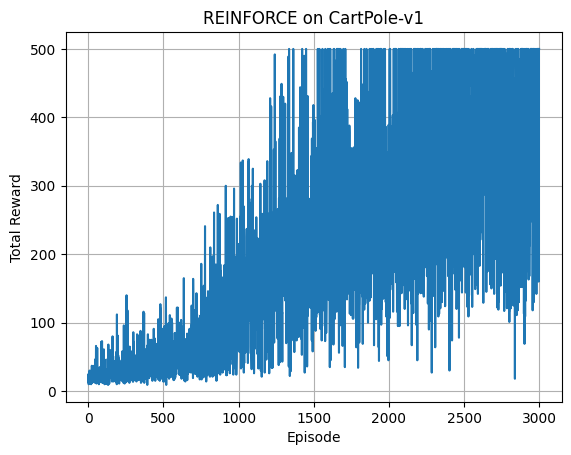

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import gymnasium as gym
import matplotlib.pyplot as plt


# --- 정책 신경망 ---
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_size):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, action_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=1)


# --- 에이전트 클래스 ---
class REINFORCEAgent:
    def __init__(self, state_dim, action_size, gamma=0.98, lr=0.0002):
        self.gamma = gamma
        self.lr = lr
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.policy_net = PolicyNetwork(state_dim, action_size).to(self.device)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.lr)

        self.memory = []  # (log_prob, reward)

    def get_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)  # (1, state_dim)
        probs = self.policy_net(state)
        m = torch.distributions.Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)

    def add(self, log_prob, reward):
        self.memory.append((log_prob, reward))

    def update(self):
        # self.policy_net.zero_grad()
        # self.pi.zero_grad()
        self.optimizer.zero_grad()

        G, loss = 0, 0
        for log_prob, reward in reversed(self.memory):
            G = reward + self.gamma * G
            loss += -log_prob * G

        loss.backward()
        self.optimizer.step()
        self.memory = []


# --- 학습 루프 ---
def train(episodes=3000, render=False):
    env = gym.make('CartPole-v1', render_mode="rgb_array" if render else None)
    state_dim = env.observation_space.shape[0]
    action_size = env.action_space.n

    agent = REINFORCEAgent(state_dim, action_size)
    reward_history = []

    print(agent.device)

    for episode in range(episodes):
        state = env.reset()[0]
        done = False
        total_reward = 0

        while not done:
            action, log_prob = agent.get_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            agent.add(log_prob, reward)
            state = next_state
            total_reward += reward

        agent.update()
        reward_history.append(total_reward)

        if (episode + 1) % 100 == 0:
            print(f"Episode {episode + 1}, Reward: {total_reward}")

    env.close()

    # --- 시각화 ---
    plt.plot(reward_history)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("REINFORCE on CartPole-v1")
    plt.grid()
    plt.show()


if __name__ == "__main__":
    train(episodes=3000)
